In [2]:
#Ejermplo de uso de finbert para clasificación de sentimientos
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results = nlp(sentences)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

C:\Users\izangale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\izangale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\izangale\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#lim

[{'label': 'Negative', 'score': 0.9966173768043518}, {'label': 'Positive', 'score': 1.0}, {'label': 'Negative', 'score': 0.9999710321426392}, {'label': 'Neutral', 'score': 0.9889441728591919}]


In [13]:
#Funciones auxiliares para el tratamiento de los datos
import pandas as pd

def load_data_tripadvisor(path:str):
    '''
    Funcion que procesa la base de datos a partir de la ruta en que se encuentra
    '''  
    df = pd.read_csv(path, sep='\t', index_col=0, names=['text', 'score'])
    df['Opinion'] = df['text'].str.split('_PROS_Liked_—_').str.get(0)
    df['PROS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(0).str.replace('_', ' ')
    df['CONS'] = df['text'].str.split('_PROS_Liked_—_').str.get(1).str.split('_CONS_Disliked_—_').str.get(1).str.replace('_', ' ')
    df['Sentiment'] = df.apply(lambda row: get_score_tripadvisor(row),axis=1)
    return df
    


#cambiar los labels
def get_score_tripadvisor(row):
    '''
    Funcion para reducir el abanico de puntuaciones a predecir.
    0: Negativa
    1: Neutral
    
    2: Positiva
    '''
    score = int(row['score'])
    if score < 3:
        return 2
    elif score < 4:
        return 0
    else:
        return 1

In [14]:
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from tqdm import tqdm

# descomente las siguientes 3 líneas para leer datos desde Google Drive, asumiendo que se trata de un fichero llamado review.csv localizado dentro de una carpeta llamada 'Datos' en su Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/MyDrive/Datos/ejemplo_review_train.csv'

# descomente la siguiente línea para leer los datos desde un archivo local, por ejemplo, asumiendo que se encuentra dentro de un directorio llamado sample_data
path = '/Users/izangale/Desktop/master/repo/master-ua/Minería de textos/TextClassification-main/01-SA-Pipeline/sample_data/ejercicio_tripadvisor.csv'

# descomente la siguiente línea para leer datos desde un URL
#path = 'https://github.com/TeachingTextMining/TextClassification/raw/main/01-SA-Pipeline/sample_data/ejemplo_review_train.csv'

#importar el archivo .py de la siguiente ruta C:\Users\usuario\entorno\master-ua\Minería de textos\TextClassification-main\00-Utils\tripadvisor.py

#carga los datos con la función load_data del archivo tripadvisor.py
df = load_data_tripadvisor(path)

# mostrar los primeros registros
data = df
data.head()


,text,score,Opinion,PROS,CONS,Sentiment
274573_7795529,Good for the money Having read the reviews -...,4,Good for the money Having read the reviews -...,Location and Price,Beds,1
274573_6611183,Central location and good price Hotel Suisse...,3,Central location and good price Hotel Suisse...,NaN,NaN,0
274573_5823077,A great hotel in the middle of everything I...,3,A great hotel in the middle of everything I...,Location,Having to be buzzed in,0
274573_5326023,Great location but expensive and some restric...,3,Great location but expensive and some restric...,NaN,NaN,0
274573_5211722,Great comfort and value Comfortable and clea...,4,Great comfort and value Comfortable and clea...,NaN,NaN,1


In [15]:
text_col = 'Opinion'  # columna del dataframe que contiene el texto (depende del formato de los datos)
class_col = 'Sentiment'  # columna del dataframe que contiene la clase (depende del formato de los datos)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

#cambia los datos de la class_col y asigna el valor negativa en caso de que sea 0, neutral en caso de que sea 1 y positiva en caso de que sea 2
#data[class_col] = data[class_col].apply(lambda x: 'negativa' if x == 0 else ('neutral' if x == 1 else 'positiva'))

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

print('Done!')

Total de instancias -> 10508
Distribución de clases:
    0: 0.1
    1: 0.787
    2: 0.113
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Good for the money  Having read the reviews - well it is Rome and you get what you pay for  Nice place and good location - remember that it is at the TOP of the Spanish steps - so if you prefer not to make the walk at the end of the day - pay more and stay at another hotel at the BOTTOM of the steps The staff were great and the bathroom was nice  The room was fine for what we paid Not recommended if you are looking for a  romantic  getaway  but for my sister and I - it was fine for all the tourist things we did  
Categoría del comentario -> 1


Done!


In [16]:
#iguala el numero de instancias a la clase que menos instancias tiene
data = data.groupby(class_col).apply(lambda x: x.sample(data[class_col].value_counts().min(), random_state=42)).reset_index(drop=True)

# obtener algunas estadísticas sobre los datos
categories = sorted(data[class_col].unique(), reverse=False)
hist= Counter(data[class_col]) 
print(f'Total de instancias -> {data.shape[0]}')
print('Distribución de clases:')
for item in sorted(hist.items(), key=lambda x: x[0]): print(f'    {item[0]}: {round(item[1]/len(data[class_col]), 3)}')

print(f'Categorías -> {categories}')
print(f'Comentario de ejemplo -> {data[text_col][0]}')
print(f'Categoría del comentario -> {data[class_col][0]}')

fig = go.Figure(layout=go.Layout(height=400, width=600))
fig.add_trace(go.Bar(x=categories, y=[hist[cat] for cat in categories]))
fig.show()

Total de instancias -> 3156
Distribución de clases:
    0: 0.333
    1: 0.333
    2: 0.333
Categorías -> [0, 1, 2]
Comentario de ejemplo ->  Ok for a few nights  but will not return  The better parts - the room was clean  clean  clean - the situation was good  about 10 minutes of slowly walking from the Termini train station - the window was sound proof  When closing  you hardly heard the noise from the street below - the bar mentioned somewhere in older reviews  was out of business when we where there  so it was no noice from there   The not-so-good parts - if you spook English to the staff at the reception  you got only a kind of cold shoulder regarding their responds to you  They gave me short-short sentences  without any polite phrases like  please  or  welcome     this regards espescially one lady  I tried to be polite and gave her smiles  but she was almost stone cold  The two other ladies at the reception were in some better mood - The room we got was in the corner of 3rd floor 

In [17]:
#creamos una lista de predicciones
predictions = []
for i in range(len(data)): 
    text = data[text_col][i]
    if len(text) > 512:
        text = text[:512]
    #prediccion de la clase
    result = nlp(text)
    predictions.append(result[0]['label'])



              precision    recall  f1-score   support

           0       0.37      0.47      0.42      1052
           1       0.54      0.69      0.61      1052
           2       0.66      0.32      0.43      1052

    accuracy                           0.49      3156
   macro avg       0.53      0.49      0.49      3156
weighted avg       0.53      0.49      0.49      3156



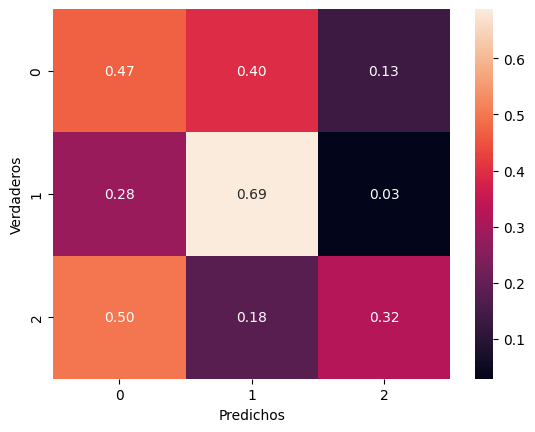

In [18]:
#ahora vamos a evaluar el modelo
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#antes de evaluar vamos a cambiar los valores de las predicciones para que coincidan con los valores de la clase
predictions_numeric = [2 if x == 'Negative' else (0 if x == 'Neutral' else 1) for x in predictions]
#ahora vamos a evaluar el modelo
print(classification_report(data[class_col], predictions_numeric))


#ahora vamos a hacer una matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(data[class_col], predictions_numeric)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=categories, yticklabels=categories)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.show()

